# **Loading the data**

In [1]:
import kagglehub
import os
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

In [2]:
images_dir = os.path.join(path, "images")
print("Contents of 'images':", os.listdir(images_dir))

Contents of 'images': ['validation', 'train', 'images']


In [3]:
train_dir = os.path.join(images_dir, "train")
validation_dir = os.path.join(images_dir, "validation")
print("Train Directory Contents:", os.listdir(train_dir))
print("Validation Directory Contents:", os.listdir(validation_dir))


Train Directory Contents: ['sad', 'fear', 'happy', 'neutral', 'surprise', 'angry', 'disgust']
Validation Directory Contents: ['sad', 'fear', 'happy', 'neutral', 'surprise', 'angry', 'disgust']


# **Dataset Overview**

In [4]:
def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

train_distribution = get_class_distribution(train_dir)
validation_distribution = get_class_distribution(validation_dir)

print("Training Class Distribution:", train_distribution)
print("Validation Class Distribution:", validation_distribution)

Training Class Distribution: {'sad': 4938, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'surprise': 3205, 'angry': 3993, 'disgust': 436}
Validation Class Distribution: {'sad': 1139, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'surprise': 797, 'angry': 960, 'disgust': 111}


In [29]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize(directory, num_samples=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, 10))
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        sample_files = os.listdir(class_dir)[:num_samples]
        for j, sample_file in enumerate(sample_files):
            img_path = os.path.join(class_dir, sample_file)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, idx * num_samples + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(class_name, fontsize=10)  # Add class name as title
    plt.tight_layout()
    plt.show()


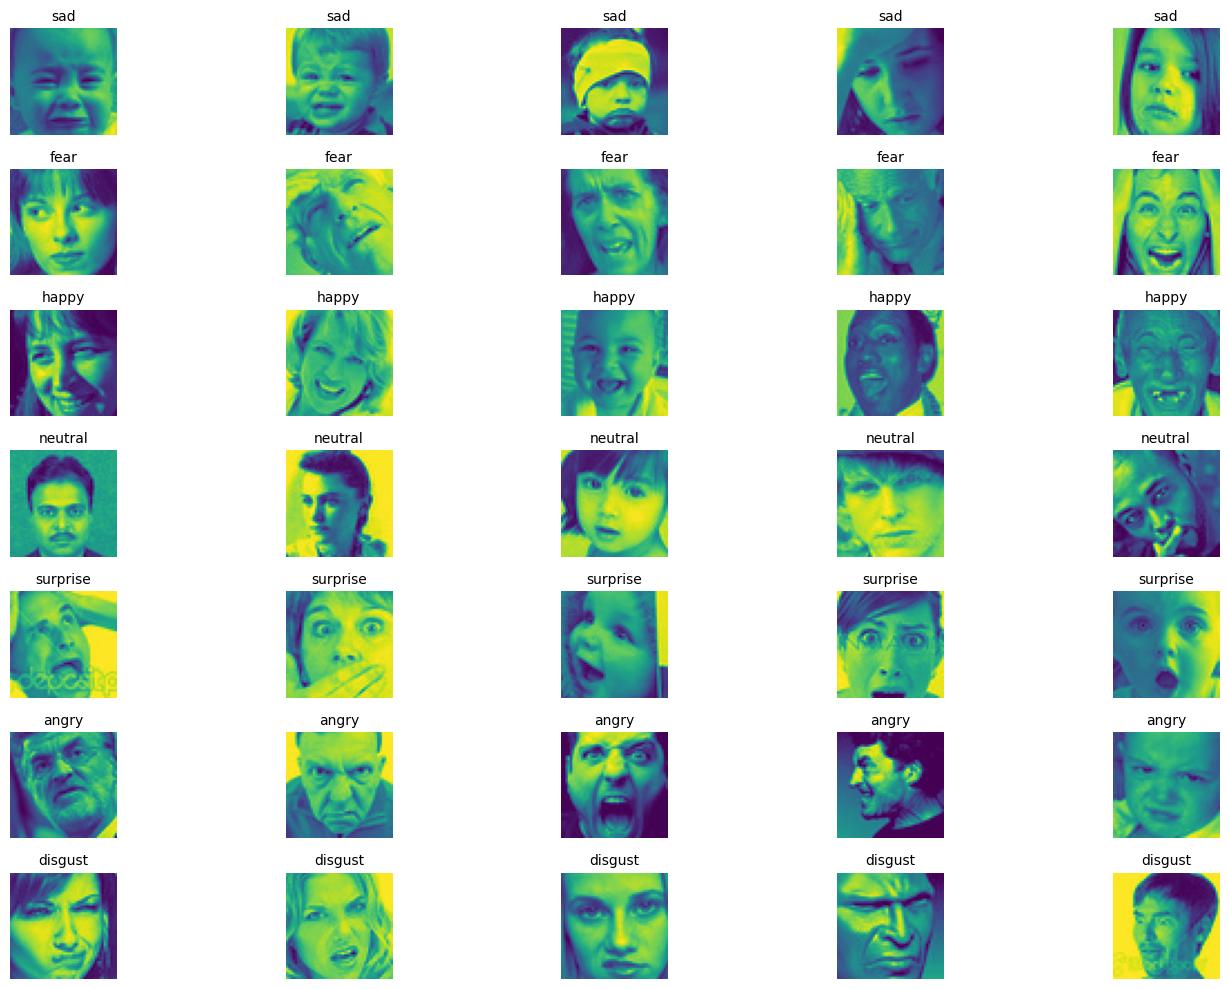

In [30]:
visualize(train_dir)

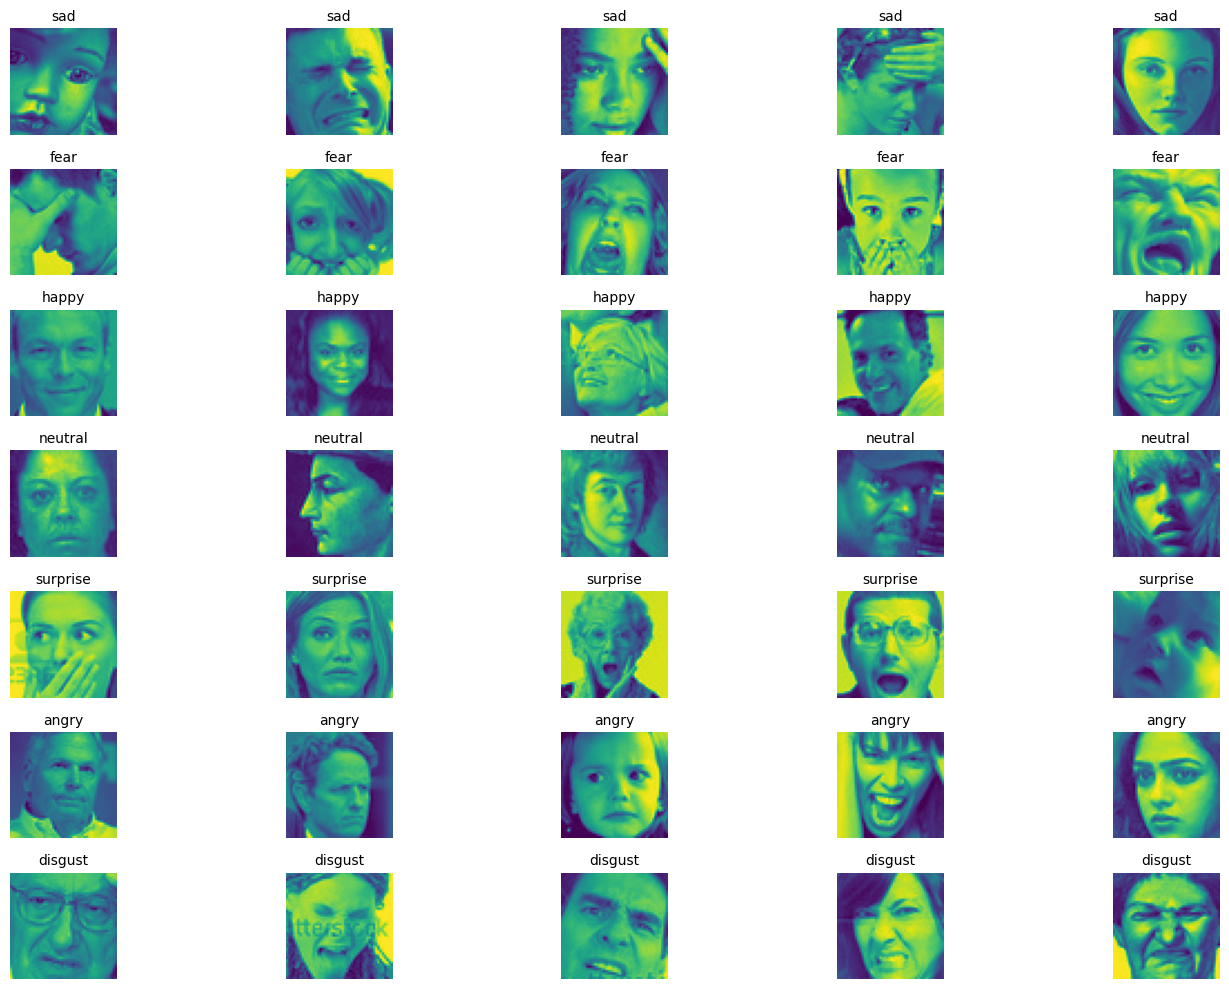

In [31]:
visualize(validation_dir)

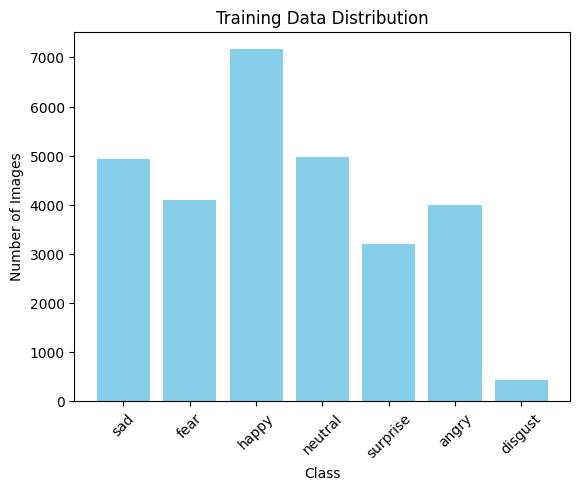

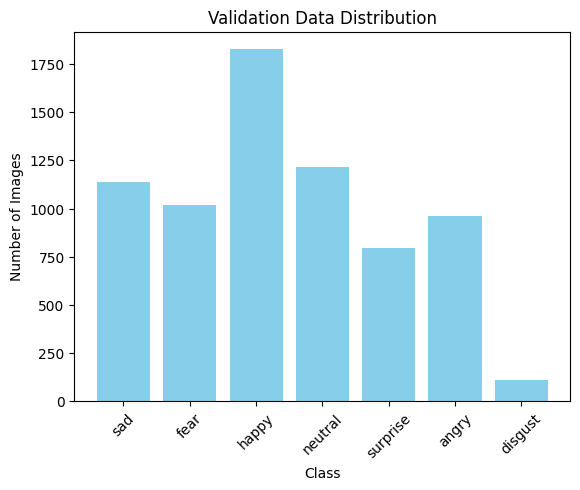

In [19]:
def class_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())
    plt.bar(classes, counts, color="skyblue")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

class_distribution(train_distribution, "Training Data Distribution")
class_distribution(validation_distribution, "Validation Data Distribution")

# **Load and preprocess the image**

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_data_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                try:
                    img = load_img(image_path, target_size=(48, 48), color_mode='grayscale')
                    img_array = img_to_array(img) / 255.0  # Normalize pixel values
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)



# **Load train and validation data**

In [9]:
x_train, y_train = load_data_from_directory(train_dir)
x_val, y_val = load_data_from_directory(validation_dir)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

# **Build CNN model**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,232,199 (16.14 MB)

 Trainable params: 4,232,199 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.2395 - loss: 1.8413 - val_accuracy: 0.2629 - val_loss: 1.8011
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.2515 - loss: 1.7965 - val_accuracy: 0.3017 - val_loss: 1.7000
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3170 - loss: 1.6874 - val_accuracy: 0.4113 - val_loss: 1.5275
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3966 - loss: 1.5452 - val_accuracy: 0.4723 - val_loss: 1.3768
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4308 - loss: 1.4637 - val_accuracy: 0.4833 - val_loss: 1.3263
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4588 - loss: 1.4024 - val_accuracy: 0.5061 - val_loss: 1.2852
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.4721 - loss: 1.3640 - val_accuracy: 0.5266 - val_loss: 1.2462
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4914 - loss: 1

# **Evaluate the model**

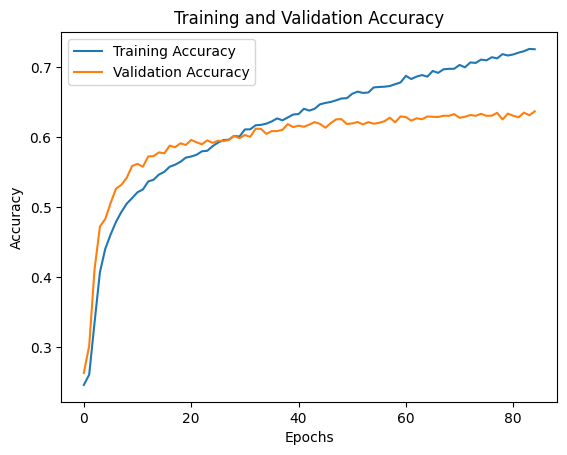

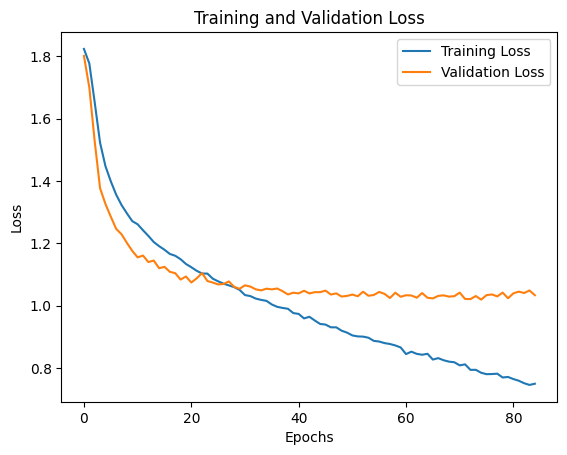

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [14]:
model.save("emotion_detector.h5")